In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install pytorch-lightning
!pip install segmentation-models-pytorch
!pip install rich
!pip install hydra-core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 7.5 MB/s 
     |████████████████████████████████| 419 kB 46.5 MB/s 
     |████████████████████████████████| 5.9 MB 40.6 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.8 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 376

In [3]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [4]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
import torchvision
from torch import nn
from torch.utils.data import Dataset ,DataLoader, random_split
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torchvision.utils import make_grid
import math
import torch.nn.functional as F
from torchvision.ops import box_convert
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import random
import matplotlib.image as mpimg
from imutils import paths
import segmentation_models_pytorch as smp
import sys
import operator

In [5]:
import src
from src.custom_segmentation_dataset import SegmentationDataset
from src.config import cfg, transform
import src.utils as utils
from src.datamodules.segmentation_datamodule import LitDataModule
from src.models.unet_module import LitModel
from src.utils.make_prediction import make_predictions
from src.utils.concatenate_patches_to_image import from_patches_to_image
from src.utils.resize_image_according_to_window_size import resize_to_multiple_of_window_scale
from src.utils.display_image_from_array import img_show_from_arr
from src.utils.display_image_from_path import img_show
from src.utils.create_patches_with_path import create_patches
from src.utils.create_images import create_img_folder

In [6]:
dm = LitDataModule()
model = LitModel()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [7]:
model = torch.load(cfg["base_output"] + "/pyimagesearch_example_lightning_testLoss0_25.pth").to(cfg["device"])

In [8]:
page1_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/18.png"
window_size = 224
# create image patches to create patch folder for model
page1_img_patches = create_patches(page1_img_path, window_size)
# create img_patches folder under page1 folder
page1_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page18"
if not (os.path.exists(page1_folder_path)):
        os.mkdir(page1_folder_path)
if not (os.path.exists(page1_folder_path + "/img_patches")):
        os.mkdir(page1_folder_path + "/img_patches")

In [9]:
# create img patch images in img_patches folder
page1_img_patch_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page18/img_patches"
create_img_folder(page1_img_patch_folder_path, "page18", page1_img_patches)

In [10]:
def get_patch_num(patches, idx):
  x = patches[idx]["filename"]
  y = x.split("_")
  z = int(y[-1].split(".")[0])
  return z

def get_patch_num_from_name(name):
  x = name.split("_")
  y = int(x[-1].split(".")[0])
  return y

def sort_predicted_patch_masks(pred_patches):
  patch_names = []
  for d in pred_patches:
      patch_names.append(d["filename"])
  patch_names

  patch_nums = []
  for name in patch_names:
    patch_nums.append(get_patch_num_from_name(name))
  patch_nums

  patch_num_dict_map = list(zip(patch_nums, pred_patches))
  sorted_patch_num_dict_map = sorted(patch_num_dict_map, key=operator.itemgetter(0))
  
  sorted_prediction_patches = []

  for zipp in sorted_patch_num_dict_map:
    sorted_prediction_patches.append(zipp[1]["predicted_patch"])

  return sorted_prediction_patches

def get_predicted_mask_from_patches(test_img_path, window_size, pred_patches):
  img = cv2.imread(test_img_path)
  img = resize_to_multiple_of_window_scale(img, window_size)
  sorted_pred_patches = sort_predicted_patch_masks(pred_patches)
  img_predicted_mask = from_patches_to_image(sorted_pred_patches, img, window_size)
  img_predicted_mask_expanded = np.expand_dims(img_predicted_mask, axis=2)
  img_predicted_mask_expanded_RGB = cv2.cvtColor(img_predicted_mask_expanded, cv2.COLOR_GRAY2RGB)
  return img_predicted_mask_expanded_RGB

def get_img_patch_paths(parent_folder_path):
  img_patches_filenames = os.listdir(parent_folder_path + "/img_patches")
  img_patches_folder_path = parent_folder_path + "/img_patches"
  img_patches_path = [os.path.join(img_patches_folder_path, file) for file in img_patches_filenames]
  return img_patches_path

In [11]:
# Now feed the model with these img patches and get prediction patches
page1_prediction_patches = []
page1_parent_folder = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page18"
page1_img_patches_path = get_img_patch_paths(page1_parent_folder)

In [12]:
for path in page1_img_patches_path:
  page1_prediction_patches.append(make_predictions(model, path))

In [ ]:
page1_pred_mask = get_predicted_mask_from_patches(page1_img_path, 224, page1_prediction_patches)
img_show_from_arr(page1_pred_mask);
cv2.imwrite("/content/drive/MyDrive/output/test_page_predicted_masks/page1_predicted_mask_from_224x224_patches_v2.png", page1_pred_mask)

In [ ]:
page1_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/1.png"
window_size = 320
# create image patches to create patch folder for model
page1_320_img_patches = create_patches(page1_img_path, window_size)
# create img_patches folder under page1 folder
page1_320_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page1_320"
if not (os.path.exists(page1_320_folder_path)):
        os.mkdir(page1_320_folder_path)
if not (os.path.exists(page1_320_folder_path + "/img_patches")):
        os.mkdir(page1_320_folder_path + "/img_patches")

In [ ]:
# create img patch images in img_patches folder
page1_320_img_patch_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page1_320/img_patches"
create_img_folder(page1_320_img_patch_folder_path, "page1", page1_320_img_patches)

In [ ]:
# Now feed the model with these img patches and get prediction patches
page1_320_prediction_patches = []
page1_320_parent_folder = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page1_320"
page1_320_img_patches_path = get_img_patch_paths(page1_320_parent_folder)

In [ ]:
for path in page1_320_img_patches_path:
  page1_320_prediction_patches.append(make_predictions(model, path))

In [ ]:
page1_320_pred_mask = get_predicted_mask_from_patches(page1_img_path, 320, page1_320_prediction_patches)
img_show_from_arr(page1_320_pred_mask)
cv2.imwrite("/content/drive/MyDrive/output/test_page_predicted_masks/page1_predicted_mask_from_320x320_patches_v2.png", page1_320_pred_mask)

In [ ]:
page1_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/1.png"
window_size = 480
# create image patches to create patch folder for model
page1_480_img_patches = create_patches(page1_img_path, window_size)
# create img_patches folder under page1 folder
page1_480_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page1_480"
if not (os.path.exists(page1_480_folder_path)):
        os.mkdir(page1_480_folder_path)

In [ ]:
# create img patch images in img_patches folder
page1_480_img_patch_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page1_480/img_patches"
create_img_folder(page1_480_img_patch_folder_path, "page1", page1_480_img_patches)

In [ ]:
# Now feed the model with these img patches and get prediction patches
page1_480_prediction_patches = []
page1_480_parent_folder = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page1_480"
page1_480_img_patches_path = get_img_patch_paths(page1_480_parent_folder)

In [ ]:
for path in page1_480_img_patches_path:
  page1_480_prediction_patches.append(make_predictions(model, path))

In [ ]:
page1_480_pred_mask = get_predicted_mask_from_patches(page1_img_path, 480, page1_480_prediction_patches)
img_show_from_arr(page1_480_pred_mask)
cv2.imwrite("/content/drive/MyDrive/output/test_page_predicted_masks/page1_predicted_mask_from_480x480_patches_v6.png", page1_480_pred_mask)

In [ ]:
len(page1_480_prediction_patches)

40

In [ ]:
page2_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/2.png"
window_size = 320
# create image patches to create patch folder for model
page2_img_patches = create_patches(page2_img_path, window_size)
# create img_patches folder under page2 folder
page2_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page2"
if not (os.path.exists(page2_folder_path)):
        os.mkdir(page2_folder_path)
if not (os.path.exists(page2_folder_path + "/img_patches")):
        os.mkdir(page2_folder_path + "/img_patches")

In [ ]:
# create img patch images in img_patches folder
page2_img_patch_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page2/img_patches"
create_img_folder(page2_img_patch_folder_path, "page2", page2_img_patches)

In [ ]:
# Now feed the model with this img patches and get prediction patches
page2_prediction_patches = []
page2_parent_folder = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page2"
page2_img_patches_path = get_img_patch_paths(page2_parent_folder)

In [ ]:
for path in page2_img_patches_path:
  page2_prediction_patches.append(make_predictions(model, path))

In [ ]:
page2_prediction_patches[0]

{'predicted_patch': array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 255,   0, 255]], dtype=uint8),
 'filename': 'page2_patch_0.png'}

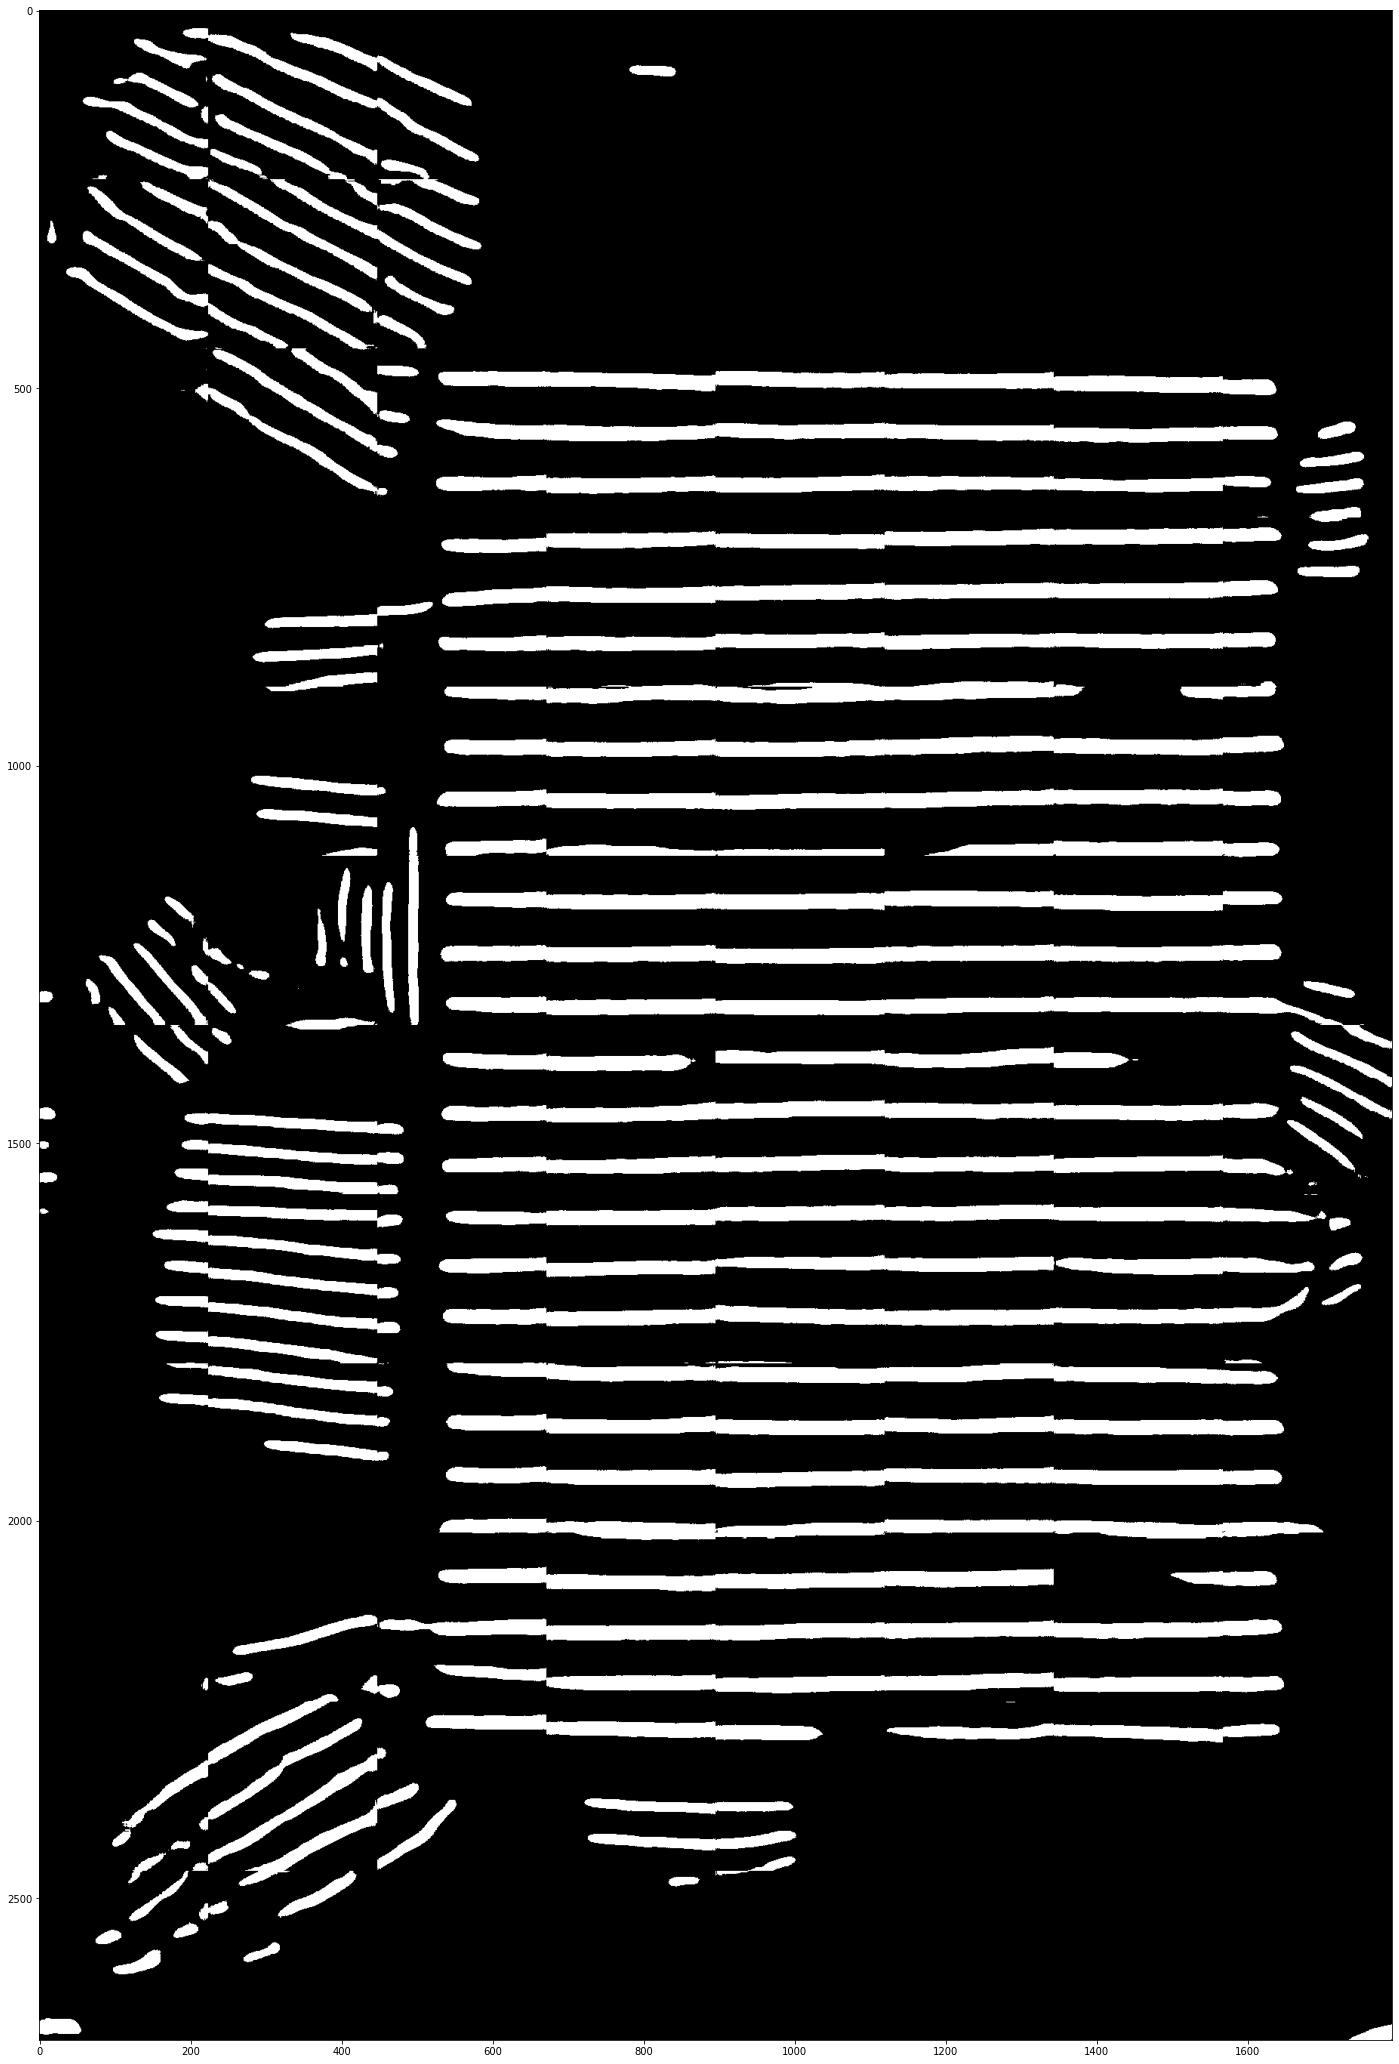

True

In [ ]:
page2_pred_mask = get_predicted_mask_from_patches(page2_img_path, 320, page2_prediction_patches)
img_show_from_arr(page2_pred_mask)
cv2.imwrite("/content/drive/MyDrive/output/test_page_predicted_masks/page2_predicted_mask_from_320x320_patches_v2.png", page2_pred_mask)

In [ ]:
page2_pred_mask.shape

(2688, 1792, 3)

In [13]:
def make_prediction_with_high_resolution_test_imgs(page_img_path,
                                                   window_size,
                                                   page_folder_path,
                                                   patch_name,
                                                   model
                                                   ):

  # create image patches to create patch folder for model
  page_img_patches = create_patches(page_img_path, window_size)

  # create img_patches folder under patch name folder
  if not (os.path.exists(page_folder_path)):
          os.mkdir(page_folder_path)

  # create img patch images in img_patches folder
  page_img_patch_folder_path = page_folder_path + "/img_patches"
  create_img_folder(page_img_patch_folder_path, patch_name, page_img_patches)

  # Now feed the model with this img patches and get prediction patches
  page_prediction_patches = []
  page_img_patches_path = get_img_patch_paths(page_folder_path)

  # make prediction with our model
  for path in page_img_patches_path:
    page_prediction_patches.append(make_predictions(model, path))

  page_pred_mask = get_predicted_mask_from_patches(page_img_path, window_size, page_prediction_patches)
  return page_pred_mask


In [ ]:
page2_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/2.png"
window_size = 320
page2_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page2"
patch_name = "page2"
model = model

page2_pred_mask = make_prediction_with_high_resolution_test_imgs(page2_img_path,
                                                                 window_size,
                                                                 page2_folder_path,
                                                                 patch_name,
                                                                 model 
                                                                 )
img_show_from_arr(page2_pred_mask)
page2_pred_name = "/content/drive/MyDrive/output/test_page_predicted_masks/page2_predicted_mask_from_320x320_patches_v3.png"
cv2.imwrite(page2_pred_name, page2_pred_mask)

In [ ]:
page3_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/3.png"
window_size = 320
page3_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page3"
patch_name = "page3"

page3_pred_mask = make_prediction_with_high_resolution_test_imgs(page3_img_path,
                                                                 window_size,
                                                                 page3_folder_path,
                                                                 patch_name,
                                                                 model
                                                                 )
img_show_from_arr(page3_pred_mask)
page3_pred_name = "/content/drive/MyDrive/output/test_page_predicted_masks/page3_predicted_mask_from_320x320_patches.png"
cv2.imwrite(page3_pred_name, page3_pred_mask)

In [ ]:
page4_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/4.png"
window_size = 320
page4_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page4"
patch_name = "page4"

page4_pred_mask = make_prediction_with_high_resolution_test_imgs(page4_img_path,
                                                                 window_size,
                                                                 page4_folder_path,
                                                                 patch_name,
                                                                 model
                                                                 )
img_show_from_arr(page4_pred_mask)
page4_pred_name = "/content/drive/MyDrive/output/test_page_predicted_masks/page4_predicted_mask_from_320x320_patches.png"
cv2.imwrite(page4_pred_name, page4_pred_mask)

In [ ]:
page5_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/5.png"
window_size = 320
page5_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page5"
patch_name = "page5"

page5_pred_mask = make_prediction_with_high_resolution_test_imgs(page5_img_path,
                                                                 window_size,
                                                                 page5_folder_path,
                                                                 patch_name,
                                                                 model
                                                                 )
img_show_from_arr(page5_pred_mask)
page5_pred_name = "/content/drive/MyDrive/output/test_page_predicted_masks/page5_predicted_mask_from_320x320_patches.png"
cv2.imwrite(page5_pred_name, page5_pred_mask)

In [ ]:
page18_img_path = "/content/drive/MyDrive/Datasets/mask-image/original/18.png"
window_size = 320
page18_folder_path = "/content/drive/MyDrive/Datasets/berat_kurar_test_images/page18"
patch_name = "page18"

page18_pred_mask = make_prediction_with_high_resolution_test_imgs(page18_img_path,
                                                                 window_size,
                                                                 page18_folder_path,
                                                                 patch_name,
                                                                 model
                                                                 )
img_show_from_arr(page18_pred_mask)
page18_pred_name = "/content/drive/MyDrive/output/test_page_predicted_masks/page18_predicted_mask_from_320x320_patches.png"
cv2.imwrite(page18_pred_name, page18_pred_mask)